In [7]:
from googleapiclient.discovery import build
import json

# API setup
api_key = 'xxx'
youtube = build('youtube', 'v3', developerKey=api_key)

# Function to get videos from a genre using tags
def get_videos_by_genre(genre, max_results=50):
    request = youtube.search().list(
        part="snippet",
        q=genre,
        type="video",
        maxResults=max_results
    )
    response = request.execute()

    videos = []
    for item in response['items']:
        video_id = item['id']['videoId']
        video_request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_id
        )
        video_response = video_request.execute()

        video_info = video_response['items'][0]['snippet']
        video_tags = video_info.get('tags', [])
        video_thumbnails = video_info.get('thumbnails', {})
        video_content = video_response['items'][0]['contentDetails']
        video_stats = video_response['items'][0]['statistics']

        # Only include videos with tags
        if video_tags:
            video_url = f"https://www.youtube.com/watch?v={video_id}"
            thumbnail_url = video_thumbnails.get('high', {}).get('url', '')
            videos.append({
                'video_id': video_id,
                'title': video_info['title'],
                'description': video_info['description'],
                'tags': video_tags,
                'published_at': video_info['publishedAt'],
                'thumbnail_url': thumbnail_url,
                'views': video_stats.get('viewCount', 0),
                'likes': video_stats.get('likeCount', 0),
                'comments': video_stats.get('commentCount', 0),
                'duration': video_content['duration'],
                'url' : video_url

            })

    return videos

# Function to get videos for multiple genres
def get_videos_by_genres(genres, max_results=50):
    all_videos = {}
    for genre in genres:
        genre_videos = get_videos_by_genre(genre, max_results)
        all_videos[genre] = genre_videos
    return all_videos

# Example genres
genres = ["news", "music", "sports", "cartoon", "cooking", "technology"]

# Extract videos related to the genres
genre_videos = get_videos_by_genres(genres)

# Save the data to a JSON file
with open('genre_videos.json', 'w') as f:
    json.dump(genre_videos, f, indent=4)

In [8]:
#create an aws s3 bucket

import json
import boto3

# Initialize S3 client
s3 = boto3.client(
    's3', 
    aws_access_key_id='xxx', 
    aws_secret_access_key='yyy', 
    region_name='ap-south-1'  # Ensure this is the correct region for the bucket
)

bucket_name = 'youtubefinal'
key = 'genre_videos.json'

try:
    # List all available buckets to confirm the bucket exists
    buckets_response = s3.list_buckets()
    bucket_names = [bucket['Name'] for bucket in buckets_response['Buckets']]
    print("Available Buckets:", bucket_names)
    
    if bucket_name not in bucket_names:
        raise Exception(f"Bucket '{bucket_name}' not found in available buckets.")

    # Load the JSON data from S3
    response = s3.get_object(Bucket=bucket_name, Key=key)
    data = json.loads(response['Body'].read().decode('utf-8'))
    print("Data loaded successfully from S3.")
    
except Exception as e:
    print(f"Error loading data from S3: {str(e)}")

Available Buckets: ['gee2127', 'youtubefinal']
Data loaded successfully from S3.


In [9]:
import json
import pandas as pd
import boto3
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

# Load JSON data from S3
s3 = boto3.client('s3')
bucket_name = 'youtubefinal'
raw_data_key = 'genre_videos.json'
response = s3.get_object(Bucket=bucket_name, Key=raw_data_key)
data = json.loads(response['Body'].read().decode('utf-8'))

# Combine data from all genres into a single list
combined_data = []
for genre, videos in data.items():
    for video in videos:
        video['genre'] = genre  # Add genre information
        combined_data.append(video)

# Convert combined data to DataFrame
df = pd.DataFrame(combined_data)

# Function to clean, lemmatize, and remove stopwords from tags
def preprocess_tags(tags):
    if isinstance(tags, list):
        tags = ' '.join(tags)
    tokens = tags.split()
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

# Process 'tags' column
if 'tags' in df.columns:
    df['tags'] = df['tags'].apply(preprocess_tags)

# Convert non-hashable types to strings to prevent issues with drop_duplicates()
df = df.apply(lambda col: col.map(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x))

# Create a 'tags_joined' column
df['tags_joined'] = df['tags']

# Clean the data
df.drop_duplicates(inplace=True)
df.fillna('', inplace=True)

# Save cleaned data locally
cleaned_data_key = 'cleaned_genre_videos.json'
df.to_json(cleaned_data_key, orient='records', lines=True)

# Upload cleaned data to S3
s3.upload_file(cleaned_data_key, bucket_name, cleaned_data_key)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DhinU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DhinU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Silhouette Score: 0.4623766584727545


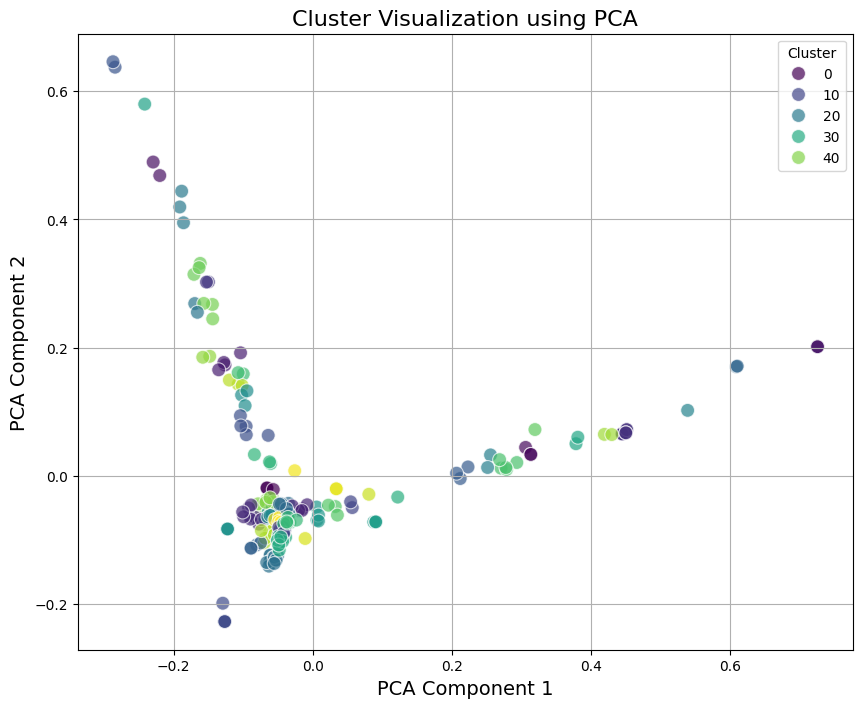

Models saved as pickle files.


In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3
from sqlalchemy import create_engine

# Load the cleaned data
df = pd.read_json('cleaned_genre_videos.json', lines=True)

# Define the tags of interest
tags_of_interest = ["news", "music", "sports", "cartoon", "cooking", "technology"]

# Create binary columns for each tag
for tag in tags_of_interest:
    df[tag] = df['tags_joined'].apply(lambda x: 1 if tag in x.lower() else 0)

# Vectorize the 'tags_joined' column using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['tags_joined'])

# Apply PCA for dimensionality reduction (2 components for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Perform K-Means clustering
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_pca, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Visualization of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization using PCA', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


# Save the vectorizer, PCA model, and KMeans model to pickle files
with open('vector.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

print("Models saved as pickle files.")


In [4]:
df

<function pandas.io.json._normalize.json_normalize(data: 'dict | list[dict]', record_path: 'str | list | None' = None, meta: 'str | list[str | list[str]] | None' = None, meta_prefix: 'str | None' = None, record_prefix: 'str | None' = None, errors: 'IgnoreRaise' = 'raise', sep: 'str' = '.', max_level: 'int | None' = None) -> 'DataFrame'>

In [31]:
import json
import pandas as pd
with open('genre_videos.json', 'r') as f:
    df= json.load(f)


In [32]:
import json
b=[]
tags_of_interest = ["news", "music", "sports", "cartoon", "cooking", "technology"]
for j in tags_of_interest:
    for i in range(len(df[j])):
        b.append(df[j][i])
import pandas as pd
df= pd.json_normalize(b)

In [33]:
df['tags']=df['tags'].apply(lambda X: " ". join (X)if isinstance (X, list) else None)

In [34]:
df['tags']

0      Kolkata Doctor Rape Case Lie Detector Test LIV...
1      TV9 Telugu tv9 news tv9 tv9 breaking news ap b...
2      Kolkata Doctor Rape Case Lie Detector Test LIV...
3      latest bangladeshi news bangla news today যমুন...
4      21082024_n_rahulgandhi_ani_136883 NDTV 24x7 br...
                             ...                        
225    future technology artificial intelligence futu...
226    Xiaomi Redmi Xiaomi MIUI Xiaomi Phone Xiaomi s...
227    inventions amazing inventions you must see coo...
228    free documentary free documentary engineering ...
229    What is Information Technology With Full Infor...
Name: tags, Length: 230, dtype: object

Silhouette Score: 0.44923990844915057


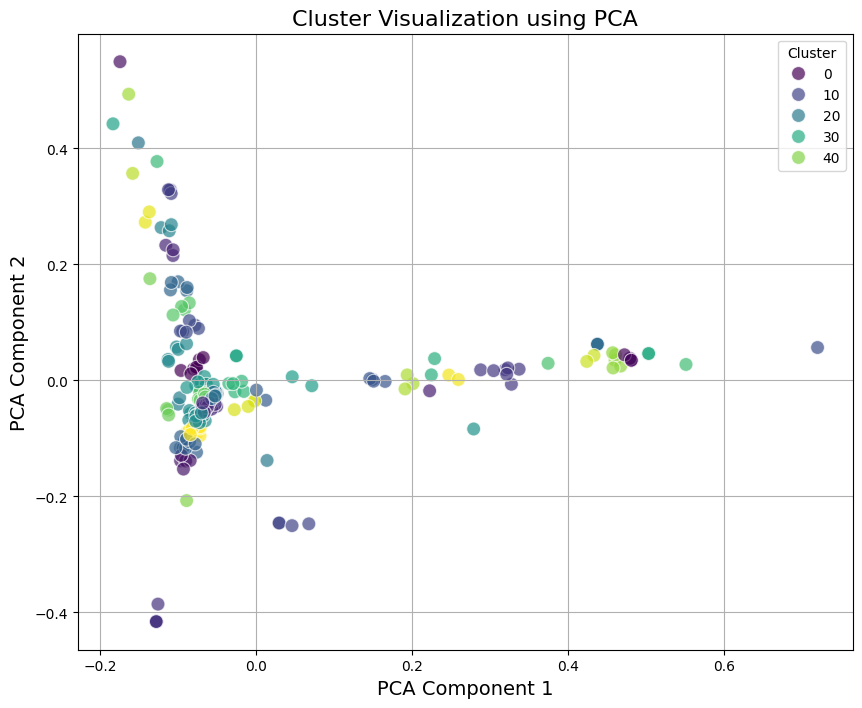

Models saved as pickle files.


In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3
from sqlalchemy import create_engine
# Vectorize the 'tags_joined' column using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['tags'])

# Apply PCA for dimensionality reduction (2 components for 2D visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Perform K-Means clustering
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_pca, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Visualization of clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Cluster Visualization using PCA', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()


# Save the vectorizer, PCA model, and KMeans model to pickle files
with open('vector.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

print("Models saved as pickle files.")


In [36]:

# # Save the clustered DataFrame as JSON
# df.to_json('clustered_genre_videos.json', orient='records', lines=True)

import boto3
from sqlalchemy import create_engine

# # Optionally, upload the clustered data back to S3
# s3 = boto3.client('s3')
# bucket_name = 'youtubefinal'
# clustered_data_key = 'clustered_genre_videos.json'
# s3.upload_file('clustered_genre_videos.json', bucket_name, clustered_data_key)

# Setup database connection to AWS RDS

db_user = 'admin'
db_password = 'xxx'
db_host = 'yyy' 
db_port = '3306'
db_name = 'Youtube'

connection_string = f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)


# Save DataFrame to AWS RDS 
df.to_sql('videos', engine, if_exists='replace', index=False)


print("Clustering based on tags completed and saved.")

# # Save the vectorizer, PCA model, and KMeans model to pickle files
# with open('vector.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)

# with open('pca.pkl', 'wb') as f:
#     pickle.dump(pca, f)

# with open('model.pkl', 'wb') as f:
#     pickle.dump(kmeans, f)

# print("Models saved as pickle files.")

Clustering based on tags completed and saved.
